# Retrieval Augmented Generation (RAG) 애플리케이션 구축: Part 2 - Chatbot Agent 

### 사용자와의 상호작용을 기억하는 메모리 기능과 다단계 검색(multi-step retrieval)을 통합한 RAG 애플리케이션을 구축

- **Part 1**: RAG 개념을 소개하고, 최소한의 구현 방법을 설명합니다.  
- **Part 2** 기존 구현을 확장하여 대화형 상호작용과 다단계 검색 프로세스를 처리할 수 있도록 ReAct agent를 생성합니다.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings

model = init_chat_model("gpt-5-mini", model_provider="openai")
# model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

# 사용할 임베딩 모델의 이름을 지정
embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [3]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

### **문서 불러오기 (Loading Documents)**

In [4]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# 주요 콘텐츠 태그만 필터링 (제목, 본문, 코드 등)
bs4_strainer = bs4.SoupStrainer(name=("h1", "h2", "h3", "p", "pre", "li"))

# WebBaseLoader 사용: requests_kwargs로 User-Agent 설정
loader = WebBaseLoader(
    web_paths=("https://botpress.com/ko/blog/llm-agents",),
    bs_kwargs={"parse_only": bs4_strainer},
    requests_kwargs={
        "headers": {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
        }
    }
)

# 문서 로드
docs = loader.load()

# 결과 확인
assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,            # 각 청크의 최대 문자 수 (1,000자)
    chunk_overlap=200,          # 청크 간 겹치는 문자 수 (200자)
    add_start_index=True,       # 원본 문서에서 각 청크의 시작 인덱스를 추적
)

# 불러온 문서를 설정한 기준에 따라 청크로 분할
all_splits = text_splitter.split_documents(docs)

# 분할된 청크(서브 문서)의 개수 출력
print(f"블로그 글을 {len(all_splits)}개의 하위 문서로 분할했습니다.")

_ = vector_store.add_documents(documents=all_splits)

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 8582
블로그 글을 11개의 하위 문서로 분할했습니다.


### 검색 단계를 **도구(tool)** 로 전환

- `@tool` 함수는 다음과 같이 `OpenAI의 function-calling` 구조로 함수들을 선언합니다.
```
{
  "name": "retrieve",
  "description": "주어진 쿼리와 관련된 정보를 검색합니다.",
  "parameters": {
    "type": "object",
    "properties": {
      "query": {
        "type": "string",
        "description": "검색할 텍스트 쿼리입니다. llm 이 생성해 줍니다."
      }
    },
    "required": ["query"]
  }
}
```

In [5]:
from langchain_core.tools import tool

# 검색(retrieve) 함수를 도구로 정의
# - response_format="content_and_artifact"로 지정하면 
# 반드시 결과를 직렬화된 content와 artifact로 반환 - Langchain이 format check
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """
    주어진 쿼리와 관련된 정보를 검색합니다. 
    query: 검색할 텍스트 쿼리입니다. llm 이 생성해 줍니다.
    """    
    # 벡터 스토어에서 유사도 검색 수행. 가장 유사한 두 개의 문서를 반환.
    retrieved_docs = vector_store.similarity_search(query)
    
    # 검색된 문서를 문자열로 직렬화
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content {doc.page_content}")
        for doc in retrieved_docs
    )
    
    # 직렬화된 결과(content)와 원본 문서 목록(artifact) 반환.
    return serialized, retrieved_docs

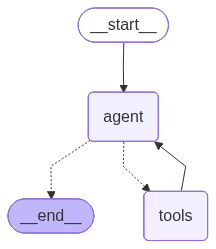

In [6]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# MemorySaver: 워크플로우의 상태를 메모리에 저장
memory = MemorySaver()

tools = [retrieve]

app = create_react_agent(model, tools, checkpointer=memory)
app

In [7]:
config = {"configurable": {"thread_id": "def1234"}} 

input_message = """
LLM 에이전트 프레임워크를 구성하는 핵심 구성 요소는 무엇인가요?
바로 대답하지 말고 주어진 도구를 사용하세요.
"""


for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    config,
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================


LLM 에이전트 프레임워크를 구성하는 핵심 구성 요소는 무엇인가요?
바로 대답하지 말고 주어진 도구를 사용하세요.

================================== Ai Message ==================================
Tool Calls:
  retrieve (call_HJ2UZsyXqf12a5rZTN6d8dyN)
 Call ID: call_HJ2UZsyXqf12a5rZTN6d8dyN
  Args:
    query: LLM 에이전트 프레임워크 핵심 구성 요소
  retrieve (call_Jz6qZ767wWUtnwTxMbEfEukz)
 Call ID: call_Jz6qZ767wWUtnwTxMbEfEukz
  Args:
    query: core components of LLM agent framework planner memory retriever executor tools safety monitoring
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://botpress.com/ko/blog/llm-agents', 'start_index': 803}
Content 무엇인가요?LLM 에이전트는 대규모 언어 모델을 사용하여 언어를 해석하고, 대화를 나누고, 작업을 수행하는 AI 기반 도구입니다.이러한 에이전트는 방대한 양의 텍스트 데이터로 학습된 복잡한 알고리즘을 기반으로 구축되어 인간과 유사한 방식으로 언어를 이해하고 생성할 수 있습니다. LLM 에이전트를 AI 에이전트, AI 챗봇, 가상 비서, 콘텐츠 생성 소프트웨어 및 기타 응용 도구에 통합할 수 있습니다.LLM 에이전트는 어떻게 작동하나요?LL

------------------------------
에이전트가 수행하는 과정은 다음과 같습니다:  

1. **작업 분해(Task Decomposition)의 표준 방법을 검색하기 위한 쿼리를 생성합니다.**  
2. **첫 번째 답변을 받은 후, 해당 방법의 일반적인 확장을 검색하는 두 번째 쿼리를 생성합니다.**  
3. **필요한 모든 문맥을 확보한 후, 최종적으로 질문에 대한 답변을 생성합니다.**  